# k-means clustering using MNIST images
**_Jake Daly_** | **_ECE 174_**

Although a relatively simple algorithm in the domain of unsupervised learning, k-means clustering provides a powerful heuristic for understanding the spread of data in a set. In this programming assignment, we will apply the k-means clustering algorithm to a well-known data set, the set of MNIST hand-written numbers, which are 28x28 pixel images. The data are converted from their 28x28 pixel 2-D representations into a more abstract 784-vector representation, so that we can more easily work with the data in the algorithm. 

We will begin by importing some relevant packages, namely <code>numpy</code>, <code>gzip</code> and <code>matplotlib</code>, to help us import the MNIST data set, as well as visualize an example of what one of these numbers looks like.



In [1]:
import numpy as np
import gzip
import matplotlib.pyplot as plt


#import help from https://stackoverflow.com/questions/40427435/extract-images-from-idx3-ubyte-file-or-gzip-via-python
f = gzip.open('train-images-idx3-ubyte.gz','r') #unzip the data set which was compressed into a gzip file on the local drive

image_size = 28 #size (in one dimension) of the images to be clustered
num_images = 60000 #number of images that we will cluster

f.read(16)
buf = f.read(image_size*image_size*num_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(num_images, image_size, image_size, 1)

image = np.asarray(data[2]).squeeze()
plt.imshow(image)
plt.show()

<Figure size 640x480 with 1 Axes>

## Interpretation of data

Granted that these MNIST numbers (or any number for that matter) are written with legible enough handwriting, it's a completely trivial task for the human brain to cluster the data. For example, if a human were given 100 random photos from this set and told that each photo belonged to one of K = 10 clusters, he or she could instantly categorize them into one of the ten clusters, with each cluster representing one of the ten digits.

Things are not this clear-cut in the high-dimensional vector spaces that algorithms and computers operate in. 

For example while it might be easy to see the above number is a 4 when visualized with the help of <code>pyplot</code>, when we look at this image represented as a 28x28 matrix of pixel values, this is not at all clear. It becomes even less clear when we convert this 2D matrix to a vector! Below we will print what this "4" looks like as a matrix:

In [2]:
print(np.shape(data))
print(np.shape(data)[0])
print(data[0,:,:,0])

(60000, 28, 28, 1)
60000
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
   18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
  253. 253. 253. 253. 225. 172. 2

## New representation of data

High-dimensional data is often not visualizable, but the beauty of the algorithms with which we operate on these vectors is that their mathematical underpinnings are still valid. Below we will rearrange the data into vectors of length 784, so that we can perform the 1D computations on them that the k-means algorithm requires. 

In [3]:
# Rearrange data from 28x28 matrices to length 784 vectors.
data_list = []
for im in range(np.shape(data)[0]):
    element = data[im,:,:,0].reshape((784)) #reshape each 2D image as a 1D vector with the same number of elements
    data_list.append(element) #append this 1D image vector to our list of data vectors

#Print the new representation of our images
print("New representation of data:")
print("Num images: %s | Length of each image: %s"%(np.shape(data_list)[0], np.shape(data_list)[1]))




New representation of data:
Num images: 60000 | Length of each image: 784


## The k-means algorithm

Below we will define our k-means algorithm, which takes as inputs a list of vectors (our images of numbers represented in 1D), along with a number of groups to cluster them in. The algorithm will perform some book keeping such as the recasting of data as <code>numpy</code> arrays, and allocation of internal variables. The group representatives have been intialized as *K* random vectors from the data_list, as these will (in general) provide starting points for the group representatives which will be closer to their final positions than if we had just initialized everything to zero. This is because we are essentially intializing each group representative to a random hand-written number (represented as a vector), and these vectors will be closer to the final value (which is an an average of all the numbers in that group), as opposed to if we intialized all to zero.

After initialization, the algorithm will enter a while loop, which will loop through the algorithm a fixed number of times, iteratively computing the closest group representatives for each vector, and then updating the group representatives to be the average (mean) of all the vectors in that group. Specifically, we will loop through each data vector, and check which group representative it is closest to. We will also keep track of the distance of this data vector from the group representative it's closest to, so that we can later on compute how much total error there is between every vector and its representative. After we determine which vectors belong to which groups, we compute the centroid of that cluster by computing the mean of all the vectors in that group, and using this value to update the group representative. 

After that, we compute the sum of the errors of each vector from it's *new* group grepresentative, and save this in a vector J_clust, so that we can see our error improving on each iteration. Once the group assignments have stopped changing from one iteration to the next, we will stop the algorithm because even if we could get incremental improvements of the values of the group representatives, the group's members have converged to their final state.

In [4]:
def kmeans(data_list, K):
    
    #Convert list to numpy array so we can perform numpy operations on it
    data_list = np.array(data_list)
    
    #Allocate lists for group representative variables and 
    group_representatives = []
    new_group_reps = []
    J_clust = []
    closest_reps_old = [0]*np.shape(data_list)[0]
    
    # initialize k group representatives
    for i in range(K):
        random_index = np.random.randint(low=0, high=len(data_list))
        new_group_reps.append(data_list[random_index])
    
    keep_going = True
    while(keep_going):
        distances_to_reps = [[] for i in range(K)]
        sum_distances_jth_clust = [0]*K
        group_representatives = new_group_reps
        
        #assign each vector to the nearest group representative
        closest_reps = []
        groups_vecs = [[] for k in range(K)]
        for vec_index in range(np.shape(data_list)[0]):
            distances = [np.linalg.norm(data_list[vec_index] - grp_rep) for grp_rep in group_representatives]
            closest_rep = np.argmin(distances)
            closest_distance = distances[closest_rep]
            distances_to_reps[closest_rep].append([vec_index, closest_distance])
            sum_distances_jth_clust[closest_rep] += distances[closest_rep]
            groups_vecs[closest_rep].append(data_list[vec_index])
            closest_reps.append(closest_rep)

        #update each group representative to be the centroid of it's vectors
        for i in range(len(groups_vecs)):

            group = np.array(groups_vecs[i])

            average = 0
            for j in range(np.shape(group)[0]):
                average += group[j,:]/np.shape(group)[0]
                
            new_group_reps[i] = average

        #compute updated Jclust
        sum_distances_to_new_rep = [0]*K
        for vec_index in range(len(data_list)):

            sum_distances_to_new_rep[closest_reps[vec_index]] += np.linalg.norm(data_list[vec_index] - new_group_reps[closest_reps[vec_index]])
        
        j_clust = np.sum(sum_distances_to_new_rep)
        J_clust.append(j_clust)
        
        number_reps_the_same = [i for i, j in zip(closest_reps, closest_reps_old) if i == j]

        if (len(number_reps_the_same)) == np.shape(data_list)[0]: # > int(.95*np.shape(data_list)[0]):
            keep_going = False
            
        else:
            keeping_going = True
            print("Convergence: %s group assignments out of %s"%(len(number_reps_the_same),np.shape(data_list)[0]))
            closest_reps_old = closest_reps
    
    return {"group_assignments": closest_reps, "group_representatives": new_group_reps, "J_clust": J_clust, "distances_to_reps": distances_to_reps}

def find_closest_10(distances_to_reps):
    
    sorted_distances = np.ndarray((len(distances_to_reps),10))
    
    for gr in range(len(distances_to_reps)):

        temp = np.array(distances_to_reps[gr])
        temp = temp[temp[:,1].argsort()]
        sorted_distances[gr, :] = temp[0:10,0]
    
    return sorted_distances
    
    

### k-means(data, K=20) for 30 iterations

We will now run the algorithm with 20 different groups, repeating for thirty iterations. Each iteration of the algorithm will have different convergences due to the different intialization of it's group representatives. Each iteration will terminate, as mentioned previously, when the group assignments for each data vector have stopped changing from one iteration to the next. 

In [5]:
out_data_master_2030 = []

for run in range(30):
    print("\n\n\n~~~~~~~~~~~~~~~Run number: %s~~~~~~~~~~~~~~~\n\n\n"%run)
    out_data = kmeans(data_list, 20)
    J_clust = out_data["J_clust"][-1]
    if run == 0:
        min_J_clust = {"Run": 0, "min_value": J_clust}
        max_J_clust = {"Run": 0, "max_value": J_clust}
    else:
        if J_clust > max_J_clust["max_value"]:
            max_J_clust["Run"] = run
            max_J_clust["max_value"] = J_clust
        
        if J_clust < min_J_clust["min_value"]:
            min_J_clust["Run"] = run
            min_J_clust["min_value"] = J_clust
                
    out_data_master_2030.append(out_data)

    

    




~~~~~~~~~~~~~~~Run number: 0~~~~~~~~~~~~~~~



Convergence: 3126 group assignments out of 60000
Convergence: 42638 group assignments out of 60000
Convergence: 51554 group assignments out of 60000
Convergence: 54323 group assignments out of 60000
Convergence: 55486 group assignments out of 60000
Convergence: 55658 group assignments out of 60000
Convergence: 55908 group assignments out of 60000
Convergence: 56669 group assignments out of 60000
Convergence: 57462 group assignments out of 60000
Convergence: 58001 group assignments out of 60000
Convergence: 58259 group assignments out of 60000
Convergence: 58392 group assignments out of 60000
Convergence: 58491 group assignments out of 60000
Convergence: 58540 group assignments out of 60000
Convergence: 58659 group assignments out of 60000
Convergence: 58802 group assignments out of 60000
Convergence: 58932 group assignments out of 60000
Convergence: 59121 group assignments out of 60000
Convergence: 59279 group assignments out of 60000
C

Convergence: 59973 group assignments out of 60000
Convergence: 59979 group assignments out of 60000
Convergence: 59985 group assignments out of 60000
Convergence: 59988 group assignments out of 60000
Convergence: 59991 group assignments out of 60000
Convergence: 59994 group assignments out of 60000
Convergence: 59996 group assignments out of 60000



~~~~~~~~~~~~~~~Run number: 2~~~~~~~~~~~~~~~



Convergence: 3344 group assignments out of 60000
Convergence: 43582 group assignments out of 60000
Convergence: 52197 group assignments out of 60000
Convergence: 54816 group assignments out of 60000
Convergence: 55977 group assignments out of 60000
Convergence: 56821 group assignments out of 60000
Convergence: 57564 group assignments out of 60000
Convergence: 58073 group assignments out of 60000
Convergence: 58335 group assignments out of 60000
Convergence: 58519 group assignments out of 60000
Convergence: 58523 group assignments out of 60000
Convergence: 58525 group assignments out of 60000
C

Convergence: 59987 group assignments out of 60000
Convergence: 59992 group assignments out of 60000
Convergence: 59992 group assignments out of 60000
Convergence: 59992 group assignments out of 60000
Convergence: 59994 group assignments out of 60000
Convergence: 59991 group assignments out of 60000
Convergence: 59993 group assignments out of 60000
Convergence: 59993 group assignments out of 60000
Convergence: 59990 group assignments out of 60000
Convergence: 59992 group assignments out of 60000
Convergence: 59994 group assignments out of 60000
Convergence: 59995 group assignments out of 60000
Convergence: 59992 group assignments out of 60000
Convergence: 59996 group assignments out of 60000
Convergence: 59999 group assignments out of 60000
Convergence: 59998 group assignments out of 60000



~~~~~~~~~~~~~~~Run number: 4~~~~~~~~~~~~~~~



Convergence: 1420 group assignments out of 60000
Convergence: 41514 group assignments out of 60000
Convergence: 50679 group assignments out of 60000
C

Convergence: 59430 group assignments out of 60000
Convergence: 59417 group assignments out of 60000
Convergence: 59440 group assignments out of 60000
Convergence: 59358 group assignments out of 60000
Convergence: 59366 group assignments out of 60000
Convergence: 59419 group assignments out of 60000
Convergence: 59448 group assignments out of 60000
Convergence: 59493 group assignments out of 60000
Convergence: 59539 group assignments out of 60000
Convergence: 59540 group assignments out of 60000
Convergence: 59593 group assignments out of 60000
Convergence: 59647 group assignments out of 60000
Convergence: 59702 group assignments out of 60000
Convergence: 59779 group assignments out of 60000
Convergence: 59813 group assignments out of 60000
Convergence: 59830 group assignments out of 60000
Convergence: 59858 group assignments out of 60000
Convergence: 59871 group assignments out of 60000
Convergence: 59886 group assignments out of 60000
Convergence: 59902 group assignments out of 60000


Convergence: 59981 group assignments out of 60000
Convergence: 59984 group assignments out of 60000
Convergence: 59982 group assignments out of 60000
Convergence: 59987 group assignments out of 60000
Convergence: 59985 group assignments out of 60000
Convergence: 59986 group assignments out of 60000
Convergence: 59986 group assignments out of 60000
Convergence: 59983 group assignments out of 60000
Convergence: 59984 group assignments out of 60000
Convergence: 59988 group assignments out of 60000
Convergence: 59991 group assignments out of 60000
Convergence: 59993 group assignments out of 60000
Convergence: 59993 group assignments out of 60000
Convergence: 59996 group assignments out of 60000
Convergence: 59993 group assignments out of 60000
Convergence: 59993 group assignments out of 60000
Convergence: 59993 group assignments out of 60000
Convergence: 59994 group assignments out of 60000
Convergence: 59998 group assignments out of 60000
Convergence: 59996 group assignments out of 60000


Convergence: 59842 group assignments out of 60000
Convergence: 59830 group assignments out of 60000
Convergence: 59853 group assignments out of 60000
Convergence: 59863 group assignments out of 60000
Convergence: 59862 group assignments out of 60000
Convergence: 59861 group assignments out of 60000
Convergence: 59862 group assignments out of 60000
Convergence: 59869 group assignments out of 60000
Convergence: 59867 group assignments out of 60000
Convergence: 59867 group assignments out of 60000
Convergence: 59873 group assignments out of 60000
Convergence: 59861 group assignments out of 60000
Convergence: 59857 group assignments out of 60000
Convergence: 59878 group assignments out of 60000
Convergence: 59882 group assignments out of 60000
Convergence: 59894 group assignments out of 60000
Convergence: 59872 group assignments out of 60000
Convergence: 59874 group assignments out of 60000
Convergence: 59892 group assignments out of 60000
Convergence: 59905 group assignments out of 60000


Convergence: 59995 group assignments out of 60000
Convergence: 59995 group assignments out of 60000
Convergence: 59997 group assignments out of 60000
Convergence: 59996 group assignments out of 60000
Convergence: 59996 group assignments out of 60000
Convergence: 59996 group assignments out of 60000
Convergence: 59994 group assignments out of 60000
Convergence: 59996 group assignments out of 60000
Convergence: 59996 group assignments out of 60000
Convergence: 59997 group assignments out of 60000
Convergence: 59996 group assignments out of 60000
Convergence: 59997 group assignments out of 60000
Convergence: 59998 group assignments out of 60000
Convergence: 59999 group assignments out of 60000
Convergence: 59999 group assignments out of 60000



~~~~~~~~~~~~~~~Run number: 10~~~~~~~~~~~~~~~



Convergence: 3243 group assignments out of 60000
Convergence: 39663 group assignments out of 60000
Convergence: 49302 group assignments out of 60000
Convergence: 52818 group assignments out of 60000


Convergence: 59763 group assignments out of 60000
Convergence: 59749 group assignments out of 60000
Convergence: 59749 group assignments out of 60000
Convergence: 59754 group assignments out of 60000
Convergence: 59753 group assignments out of 60000
Convergence: 59749 group assignments out of 60000
Convergence: 59782 group assignments out of 60000
Convergence: 59783 group assignments out of 60000
Convergence: 59792 group assignments out of 60000
Convergence: 59820 group assignments out of 60000
Convergence: 59826 group assignments out of 60000
Convergence: 59813 group assignments out of 60000
Convergence: 59826 group assignments out of 60000
Convergence: 59813 group assignments out of 60000
Convergence: 59796 group assignments out of 60000
Convergence: 59771 group assignments out of 60000
Convergence: 59727 group assignments out of 60000
Convergence: 59720 group assignments out of 60000
Convergence: 59731 group assignments out of 60000
Convergence: 59728 group assignments out of 60000


Convergence: 59988 group assignments out of 60000
Convergence: 59986 group assignments out of 60000
Convergence: 59982 group assignments out of 60000
Convergence: 59984 group assignments out of 60000
Convergence: 59989 group assignments out of 60000
Convergence: 59990 group assignments out of 60000
Convergence: 59989 group assignments out of 60000
Convergence: 59992 group assignments out of 60000
Convergence: 59994 group assignments out of 60000
Convergence: 59993 group assignments out of 60000
Convergence: 59998 group assignments out of 60000
Convergence: 59999 group assignments out of 60000



~~~~~~~~~~~~~~~Run number: 13~~~~~~~~~~~~~~~



Convergence: 5582 group assignments out of 60000
Convergence: 43329 group assignments out of 60000
Convergence: 50613 group assignments out of 60000
Convergence: 54333 group assignments out of 60000
Convergence: 56008 group assignments out of 60000
Convergence: 56919 group assignments out of 60000
Convergence: 57623 group assignments out of 60000


Convergence: 59669 group assignments out of 60000
Convergence: 59698 group assignments out of 60000
Convergence: 59731 group assignments out of 60000
Convergence: 59773 group assignments out of 60000
Convergence: 59796 group assignments out of 60000
Convergence: 59830 group assignments out of 60000
Convergence: 59835 group assignments out of 60000
Convergence: 59864 group assignments out of 60000
Convergence: 59869 group assignments out of 60000
Convergence: 59872 group assignments out of 60000
Convergence: 59881 group assignments out of 60000
Convergence: 59891 group assignments out of 60000
Convergence: 59888 group assignments out of 60000
Convergence: 59906 group assignments out of 60000
Convergence: 59918 group assignments out of 60000
Convergence: 59927 group assignments out of 60000
Convergence: 59925 group assignments out of 60000
Convergence: 59929 group assignments out of 60000
Convergence: 59931 group assignments out of 60000
Convergence: 59956 group assignments out of 60000


Convergence: 59569 group assignments out of 60000
Convergence: 59614 group assignments out of 60000
Convergence: 59637 group assignments out of 60000
Convergence: 59632 group assignments out of 60000
Convergence: 59656 group assignments out of 60000
Convergence: 59675 group assignments out of 60000
Convergence: 59682 group assignments out of 60000
Convergence: 59682 group assignments out of 60000
Convergence: 59719 group assignments out of 60000
Convergence: 59755 group assignments out of 60000
Convergence: 59771 group assignments out of 60000
Convergence: 59818 group assignments out of 60000
Convergence: 59813 group assignments out of 60000
Convergence: 59824 group assignments out of 60000
Convergence: 59813 group assignments out of 60000
Convergence: 59836 group assignments out of 60000
Convergence: 59847 group assignments out of 60000
Convergence: 59860 group assignments out of 60000
Convergence: 59868 group assignments out of 60000
Convergence: 59882 group assignments out of 60000


Convergence: 57974 group assignments out of 60000
Convergence: 58441 group assignments out of 60000
Convergence: 58813 group assignments out of 60000
Convergence: 59058 group assignments out of 60000
Convergence: 59236 group assignments out of 60000
Convergence: 59276 group assignments out of 60000
Convergence: 59378 group assignments out of 60000
Convergence: 59475 group assignments out of 60000
Convergence: 59547 group assignments out of 60000
Convergence: 59637 group assignments out of 60000
Convergence: 59725 group assignments out of 60000
Convergence: 59798 group assignments out of 60000
Convergence: 59816 group assignments out of 60000
Convergence: 59839 group assignments out of 60000
Convergence: 59838 group assignments out of 60000
Convergence: 59860 group assignments out of 60000
Convergence: 59853 group assignments out of 60000
Convergence: 59856 group assignments out of 60000
Convergence: 59873 group assignments out of 60000
Convergence: 59871 group assignments out of 60000


Convergence: 59552 group assignments out of 60000
Convergence: 59511 group assignments out of 60000
Convergence: 59460 group assignments out of 60000
Convergence: 59440 group assignments out of 60000
Convergence: 59430 group assignments out of 60000
Convergence: 59409 group assignments out of 60000
Convergence: 59446 group assignments out of 60000
Convergence: 59468 group assignments out of 60000
Convergence: 59531 group assignments out of 60000
Convergence: 59578 group assignments out of 60000
Convergence: 59634 group assignments out of 60000
Convergence: 59650 group assignments out of 60000
Convergence: 59685 group assignments out of 60000
Convergence: 59727 group assignments out of 60000
Convergence: 59779 group assignments out of 60000
Convergence: 59827 group assignments out of 60000
Convergence: 59841 group assignments out of 60000
Convergence: 59852 group assignments out of 60000
Convergence: 59869 group assignments out of 60000
Convergence: 59891 group assignments out of 60000


Convergence: 59533 group assignments out of 60000
Convergence: 59618 group assignments out of 60000
Convergence: 59664 group assignments out of 60000
Convergence: 59745 group assignments out of 60000
Convergence: 59763 group assignments out of 60000
Convergence: 59812 group assignments out of 60000
Convergence: 59844 group assignments out of 60000
Convergence: 59866 group assignments out of 60000
Convergence: 59874 group assignments out of 60000
Convergence: 59883 group assignments out of 60000
Convergence: 59912 group assignments out of 60000
Convergence: 59932 group assignments out of 60000
Convergence: 59938 group assignments out of 60000
Convergence: 59934 group assignments out of 60000
Convergence: 59937 group assignments out of 60000
Convergence: 59946 group assignments out of 60000
Convergence: 59954 group assignments out of 60000
Convergence: 59954 group assignments out of 60000
Convergence: 59969 group assignments out of 60000
Convergence: 59960 group assignments out of 60000


Convergence: 59727 group assignments out of 60000
Convergence: 59768 group assignments out of 60000
Convergence: 59783 group assignments out of 60000
Convergence: 59783 group assignments out of 60000
Convergence: 59811 group assignments out of 60000
Convergence: 59841 group assignments out of 60000
Convergence: 59856 group assignments out of 60000
Convergence: 59875 group assignments out of 60000
Convergence: 59888 group assignments out of 60000
Convergence: 59890 group assignments out of 60000
Convergence: 59902 group assignments out of 60000
Convergence: 59906 group assignments out of 60000
Convergence: 59920 group assignments out of 60000
Convergence: 59913 group assignments out of 60000
Convergence: 59913 group assignments out of 60000
Convergence: 59924 group assignments out of 60000
Convergence: 59942 group assignments out of 60000
Convergence: 59931 group assignments out of 60000
Convergence: 59933 group assignments out of 60000
Convergence: 59910 group assignments out of 60000


Convergence: 59979 group assignments out of 60000
Convergence: 59981 group assignments out of 60000
Convergence: 59985 group assignments out of 60000
Convergence: 59981 group assignments out of 60000
Convergence: 59981 group assignments out of 60000
Convergence: 59973 group assignments out of 60000
Convergence: 59985 group assignments out of 60000
Convergence: 59996 group assignments out of 60000
Convergence: 59994 group assignments out of 60000
Convergence: 59998 group assignments out of 60000
Convergence: 59997 group assignments out of 60000
Convergence: 59996 group assignments out of 60000
Convergence: 59996 group assignments out of 60000
Convergence: 59993 group assignments out of 60000
Convergence: 59991 group assignments out of 60000
Convergence: 59994 group assignments out of 60000
Convergence: 59995 group assignments out of 60000
Convergence: 59993 group assignments out of 60000
Convergence: 59994 group assignments out of 60000
Convergence: 59992 group assignments out of 60000


Convergence: 59421 group assignments out of 60000
Convergence: 59488 group assignments out of 60000
Convergence: 59535 group assignments out of 60000
Convergence: 59628 group assignments out of 60000
Convergence: 59686 group assignments out of 60000
Convergence: 59717 group assignments out of 60000
Convergence: 59770 group assignments out of 60000
Convergence: 59795 group assignments out of 60000
Convergence: 59824 group assignments out of 60000
Convergence: 59837 group assignments out of 60000
Convergence: 59853 group assignments out of 60000
Convergence: 59879 group assignments out of 60000
Convergence: 59897 group assignments out of 60000
Convergence: 59900 group assignments out of 60000
Convergence: 59922 group assignments out of 60000
Convergence: 59929 group assignments out of 60000
Convergence: 59937 group assignments out of 60000
Convergence: 59924 group assignments out of 60000
Convergence: 59933 group assignments out of 60000
Convergence: 59939 group assignments out of 60000


Convergence: 59772 group assignments out of 60000
Convergence: 59779 group assignments out of 60000
Convergence: 59797 group assignments out of 60000
Convergence: 59804 group assignments out of 60000
Convergence: 59840 group assignments out of 60000
Convergence: 59864 group assignments out of 60000
Convergence: 59898 group assignments out of 60000
Convergence: 59910 group assignments out of 60000
Convergence: 59915 group assignments out of 60000
Convergence: 59918 group assignments out of 60000
Convergence: 59933 group assignments out of 60000
Convergence: 59950 group assignments out of 60000
Convergence: 59956 group assignments out of 60000
Convergence: 59952 group assignments out of 60000
Convergence: 59963 group assignments out of 60000
Convergence: 59967 group assignments out of 60000
Convergence: 59963 group assignments out of 60000
Convergence: 59963 group assignments out of 60000
Convergence: 59974 group assignments out of 60000
Convergence: 59978 group assignments out of 60000


Convergence: 59850 group assignments out of 60000
Convergence: 59843 group assignments out of 60000
Convergence: 59841 group assignments out of 60000
Convergence: 59864 group assignments out of 60000
Convergence: 59874 group assignments out of 60000
Convergence: 59851 group assignments out of 60000
Convergence: 59839 group assignments out of 60000
Convergence: 59800 group assignments out of 60000
Convergence: 59792 group assignments out of 60000
Convergence: 59759 group assignments out of 60000
Convergence: 59728 group assignments out of 60000
Convergence: 59706 group assignments out of 60000
Convergence: 59677 group assignments out of 60000
Convergence: 59627 group assignments out of 60000
Convergence: 59630 group assignments out of 60000
Convergence: 59650 group assignments out of 60000
Convergence: 59632 group assignments out of 60000
Convergence: 59651 group assignments out of 60000
Convergence: 59682 group assignments out of 60000
Convergence: 59696 group assignments out of 60000


### Plot max and min J_clust runs

Performing 30 iterations of the algorithm for K = 20 groups, we observe decent fidelity of various digits represented by the group representatives.
- How do max and min compare?
- Do they converge to roughly the same value?
- Are any of the group representatives ambiguous which numbers they represent?


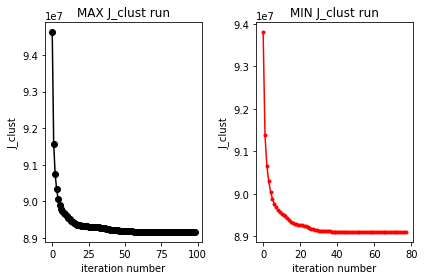

In [21]:

# Plot the min and max J_clust runs

MAX_run = out_data_master_2030[max_J_clust["Run"]]
MIN_run = out_data_master_2030[min_J_clust["Run"]]

fig1 = plt.figure()
plt.title('Group representatives from MIN run')

for i in range(np.shape(MIN_run["group_representatives"])[0]):
    
    image = np.array(MIN_run["group_representatives"])[i].reshape((28,28))
    sub = fig1.add_subplot(4, 5, i + 1)
    plt.axis('off')
    sub.imshow(image)

# fig2 = plt.figure()
# plt.title('Group representatives from MIN run')

# for i in range(np.shape(MIN_run["group_representatives"])[0]):
#     image = np.array(MIN_run["group_representatives"])[i].reshape((28,28))
#     sub = fig2.add_subplot(4, 5, i + 1)
#     plt.axis('off')
#     sub.imshow(image)

# Convergence of J_clust in MAX and MIN runs
plt.subplot(1, 2, 1)
plt.plot(MAX_run["J_clust"], 'ko-')
plt.title('MAX J_clust run')
plt.xlabel('iteration number')
plt.ylabel('J_clust')


plt.subplot(1, 2, 2)
plt.plot(MIN_run["J_clust"], 'r.-')
plt.title('MIN J_clust run')
plt.xlabel('iteration number')
plt.ylabel('J_clust')

plt.tight_layout()

plt.show()

To see how accurate our results are, we can look at the ten closest data vectors (images) to the group representatives. If most of these ten closest data vectors resemble the number that the group representative resembles, then we can reasonably assume

c:\users\jaked\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


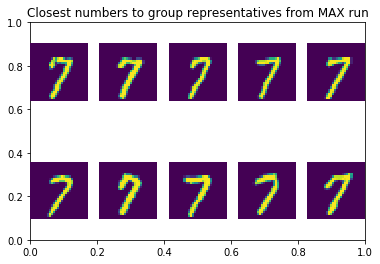

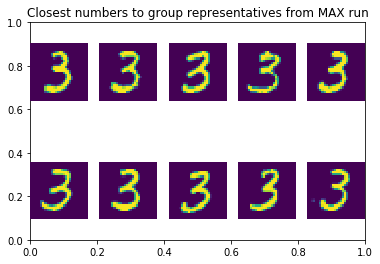

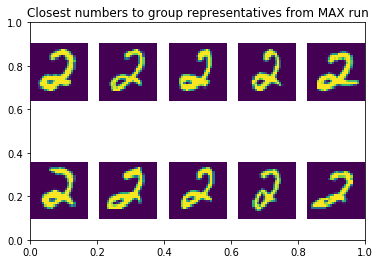

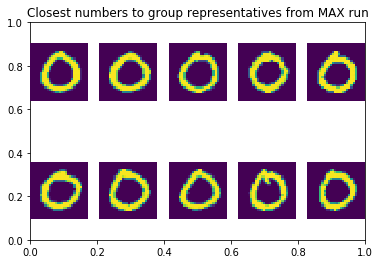

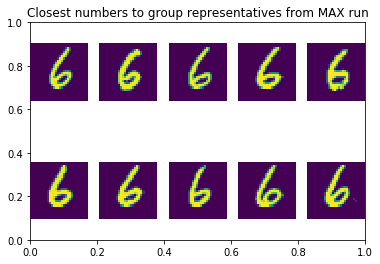

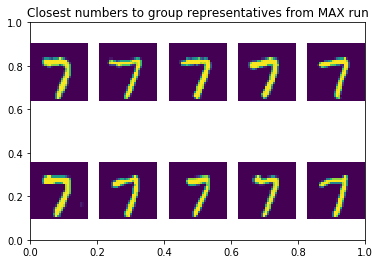

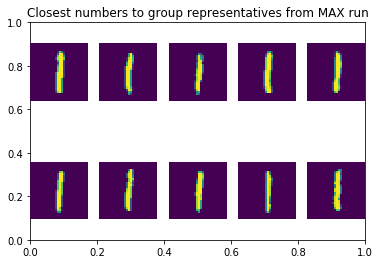

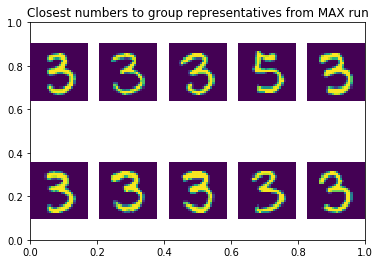

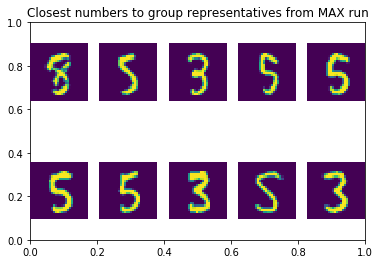

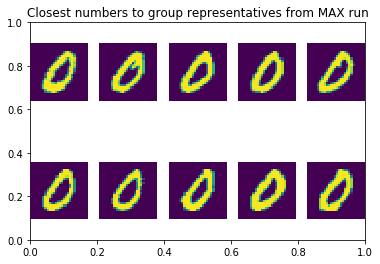

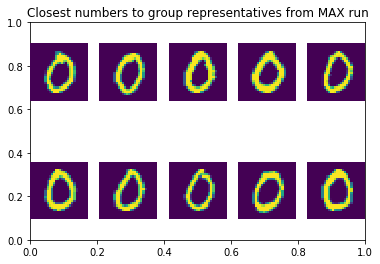

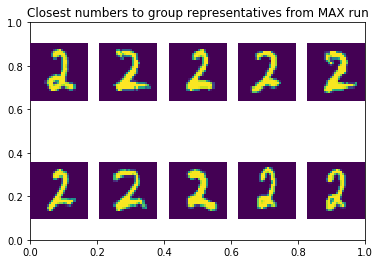

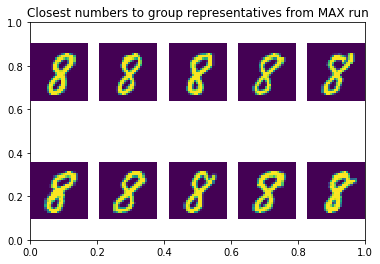

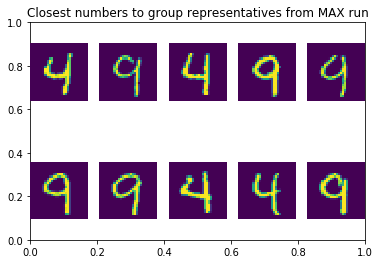

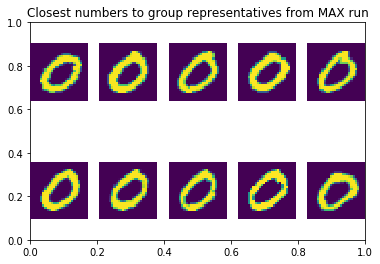

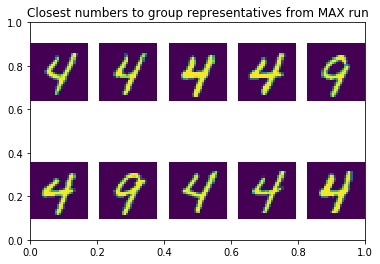

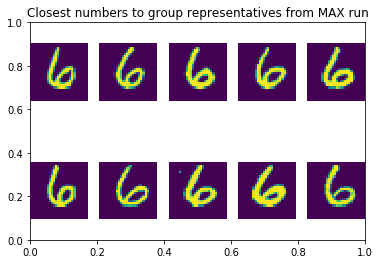

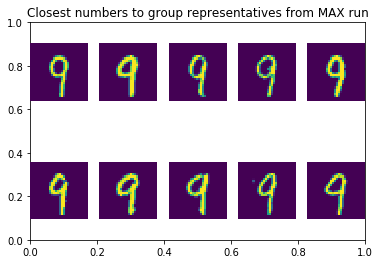

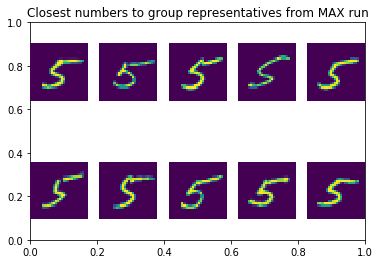

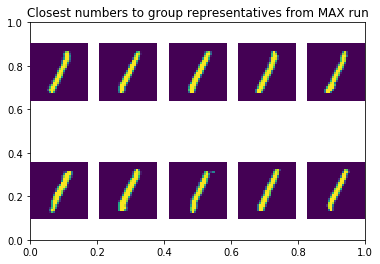

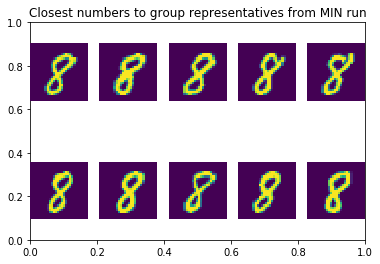

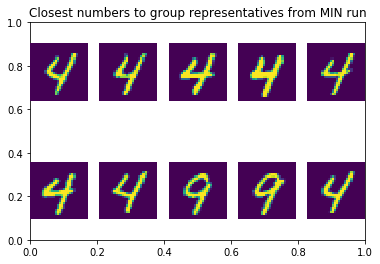

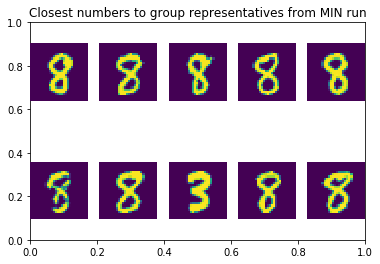

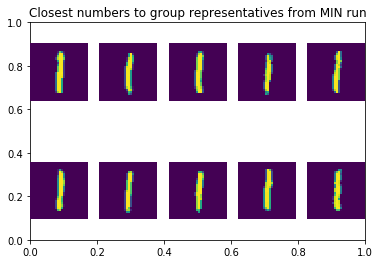

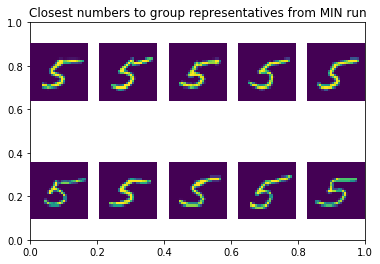

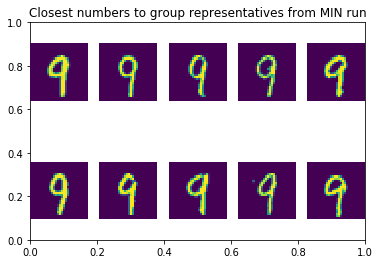

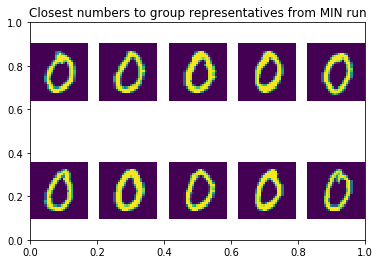

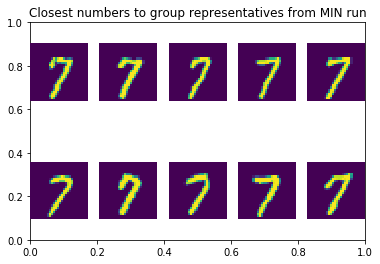

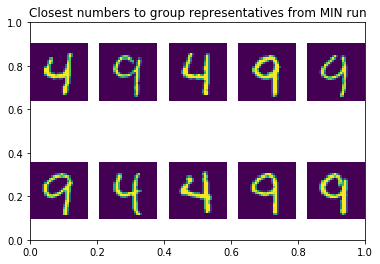

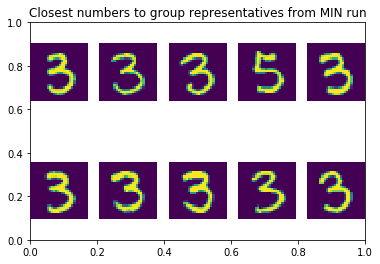

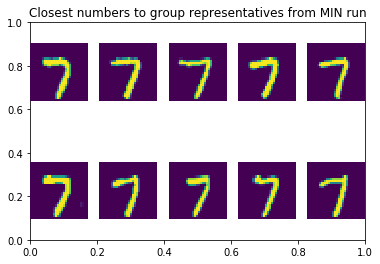

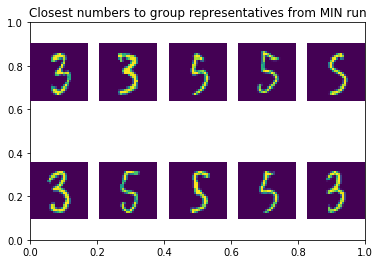

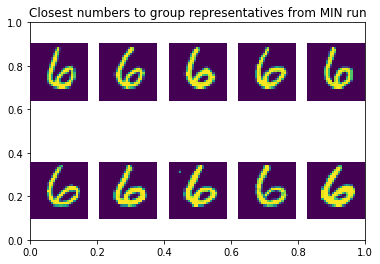

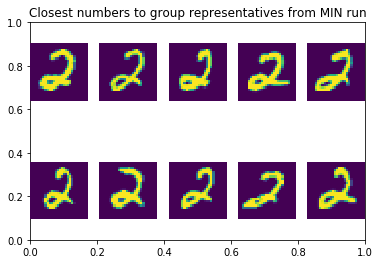

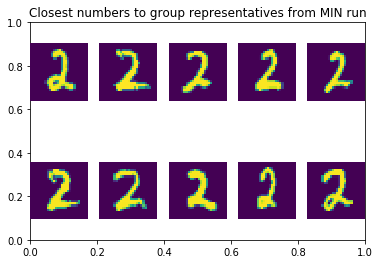

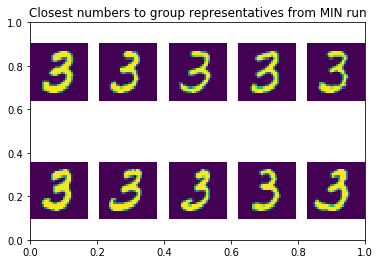

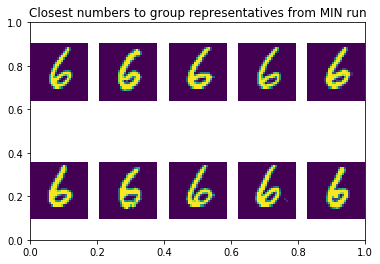

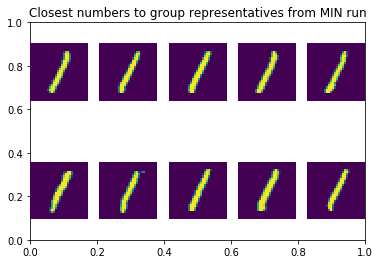

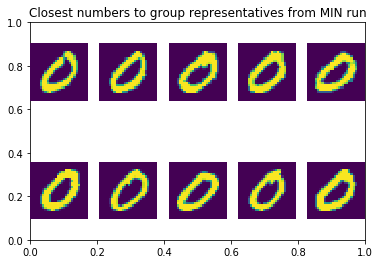

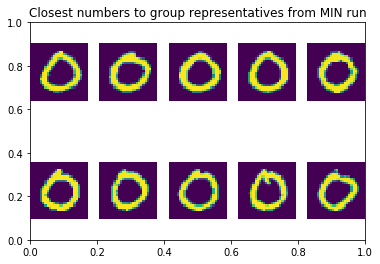

In [22]:
# Print the closest ten data vectors to the group representatives of the max and min runs:
closest_10_for_each_grouprep_MAX = find_closest_10(MAX_run["distances_to_reps"])
closest_10_for_each_grouprep_MIN = find_closest_10(MIN_run["distances_to_reps"])

# print(np.shape(MAX_run["distances_to_reps"]))
# print(np.shape(closest_10_for_each_grouprep_MAX)[0])

for index in range(np.shape(closest_10_for_each_grouprep_MAX)[0]):
    
    fig = plt.figure()
    plt.title('Closest numbers to group representatives from MAX run')
    for index_inner in range(np.shape(closest_10_for_each_grouprep_MAX)[1]):
        
        image = data_list[int(closest_10_for_each_grouprep_MAX[index,index_inner])].reshape((28,28))
        sub = fig.add_subplot(2, 5, index_inner + 1)
        plt.axis('off')
        sub.imshow(image)

for index in range(np.shape(closest_10_for_each_grouprep_MIN)[0]):
    
    fig = plt.figure()
    plt.title('Closest numbers to group representatives from MIN run')
    for index_inner in range(np.shape(closest_10_for_each_grouprep_MIN)[1]):
        
        image = data_list[int(closest_10_for_each_grouprep_MIN[index,index_inner])].reshape((28,28))
        sub = fig.add_subplot(2, 5, index_inner + 1)
        plt.axis('off')
        sub.imshow(image)



To gauge how well our algorithm was able to cluster numbers, we can look at the 10 closest (as measured by Euclidian norm) images to each group representative on the run where we had the highest final $J_{clust}$ (most amount of error) and smallest final $J_{clust}$ (least amount of error). When we look at the image above of the 20 group representatives from the max run for example, the very first one resembles a 6. We can plot the 10 closest points to this one, and indeed, all ten closest points are 6's!:

![title](img/2030/max0-3-0errors.png)

Although this is what we'd expect with each group representative, this is not guarunteed to be the case. In fact, if we look at the ten closest points to a couple of the other group representatives, we can see some of these images are not the same identifiable number that the group representative is. Looking at the 8th group representative in the plot, it most closely looks like a 3, but when we plot the 10 closest neighbors, we see that 4 of 10 are actually images of 8's:

![title](img/2030/max8-3-4errors.png)

For the max run where the $J_{clust}$ error was the highest, there occurred an extreme case where three different digits were represented in the 10 samples closest to the group representative:

![title](img/2030/max5-5-4errors.png)

It's not completely clear looking at these ten photos which number the group representative is actually supposed to be representing. What this means in terms of our algorithm is that as this group representative was being updated on each iteration, it found a local minima in the error (distance) to members in it's cluster; once it converged to this minima (which spatially was in between several different groups of *actual* numbers, the closest data points latched onto it. Because they stopped changing groups, the algorithm eventually terminated as this was the end case. 

One way we can try to quantify the accuracy of the max run is by taking the number of correct classifications of digits out of the ones we've chosen to observe (the ten closest to each of twenty group representatives). Although this method is subject to human opinion (i.e., I am the one decided what number a group representative most closely resembles), it will still give us *some* metric as to how well the algorithm worked. **_For the "max" $J_{clust}$ run, the algorithm correctly classified 181/200 (90.5%) images_** From tallying up instances where one of the ten closest numbers was not the same as digit depicted by the group representative, it is clear that the algorithm struggled mostly distinguishing between 4s and 9s, and between 5s and 3s.

We can apply these same methods to the run with the minimum $J_{clust}$. Whereas the final value of $J_{clust}$ for the max run was about 89,368,067.20, this same value for the minimum run was 88,858,587.64. If we tally up the total number of "wrong" classifications from the minimum run, we obtain 14 misclassifications. **_This means that for the min $J_{clust}$ run, it correctly classified 186/200 (93%) images, or a ~2.5% improvement of the max run!_**


In [30]:
print(max_J_clust["max_value"]/min_J_clust["min_value"])
print(min_J_clust["min_value"])
print(max_J_clust["max_value"])

1.0042590045044535
99607179.07995605
100031406.5043335


### k-means(data, K=10) for 20 iterations

In [8]:
out_data_master_1020 = []

for run in range(20):
    print("\n\n\n~~~~~~~~~~~~~~~Run number: %s~~~~~~~~~~~~~~~\n\n\n"%run)
    out_data = kmeans(data_list, 10)
    J_clust = out_data["J_clust"][-1]
    if run == 0:
        min_J_clust = {"Run": 0, "min_value": J_clust}
        max_J_clust = {"Run": 0, "max_value": J_clust}
    else:
        if J_clust > max_J_clust["max_value"]:
            max_J_clust["Run"] = run
            max_J_clust["max_value"] = J_clust
        
        if J_clust < min_J_clust["min_value"]:
            min_J_clust["Run"] = run
            min_J_clust["min_value"] = J_clust
                
    out_data_master_1020.append(out_data)






~~~~~~~~~~~~~~~Run number: 0~~~~~~~~~~~~~~~



Convergence: 1769 group assignments out of 60000
Convergence: 44810 group assignments out of 60000
Convergence: 52969 group assignments out of 60000
Convergence: 54265 group assignments out of 60000
Convergence: 55661 group assignments out of 60000
Convergence: 56955 group assignments out of 60000
Convergence: 57664 group assignments out of 60000
Convergence: 58173 group assignments out of 60000
Convergence: 58394 group assignments out of 60000
Convergence: 58515 group assignments out of 60000
Convergence: 58348 group assignments out of 60000
Convergence: 58010 group assignments out of 60000
Convergence: 57715 group assignments out of 60000
Convergence: 57508 group assignments out of 60000
Convergence: 57512 group assignments out of 60000
Convergence: 57747 group assignments out of 60000
Convergence: 58154 group assignments out of 60000
Convergence: 58572 group assignments out of 60000
Convergence: 58869 group assignments out of 60000
C

Convergence: 59970 group assignments out of 60000
Convergence: 59977 group assignments out of 60000
Convergence: 59976 group assignments out of 60000
Convergence: 59972 group assignments out of 60000
Convergence: 59972 group assignments out of 60000
Convergence: 59964 group assignments out of 60000
Convergence: 59961 group assignments out of 60000
Convergence: 59960 group assignments out of 60000
Convergence: 59955 group assignments out of 60000
Convergence: 59964 group assignments out of 60000
Convergence: 59965 group assignments out of 60000
Convergence: 59969 group assignments out of 60000
Convergence: 59977 group assignments out of 60000
Convergence: 59976 group assignments out of 60000
Convergence: 59983 group assignments out of 60000
Convergence: 59979 group assignments out of 60000
Convergence: 59975 group assignments out of 60000
Convergence: 59980 group assignments out of 60000
Convergence: 59984 group assignments out of 60000
Convergence: 59980 group assignments out of 60000


Convergence: 59977 group assignments out of 60000
Convergence: 59981 group assignments out of 60000
Convergence: 59978 group assignments out of 60000
Convergence: 59983 group assignments out of 60000
Convergence: 59973 group assignments out of 60000
Convergence: 59975 group assignments out of 60000
Convergence: 59972 group assignments out of 60000
Convergence: 59969 group assignments out of 60000
Convergence: 59972 group assignments out of 60000
Convergence: 59983 group assignments out of 60000
Convergence: 59994 group assignments out of 60000
Convergence: 59994 group assignments out of 60000
Convergence: 59992 group assignments out of 60000
Convergence: 59992 group assignments out of 60000
Convergence: 59992 group assignments out of 60000
Convergence: 59992 group assignments out of 60000
Convergence: 59993 group assignments out of 60000
Convergence: 59991 group assignments out of 60000
Convergence: 59995 group assignments out of 60000
Convergence: 59994 group assignments out of 60000


Convergence: 59956 group assignments out of 60000
Convergence: 59961 group assignments out of 60000
Convergence: 59977 group assignments out of 60000
Convergence: 59980 group assignments out of 60000
Convergence: 59977 group assignments out of 60000
Convergence: 59972 group assignments out of 60000
Convergence: 59973 group assignments out of 60000
Convergence: 59970 group assignments out of 60000
Convergence: 59974 group assignments out of 60000
Convergence: 59963 group assignments out of 60000
Convergence: 59957 group assignments out of 60000
Convergence: 59959 group assignments out of 60000
Convergence: 59967 group assignments out of 60000
Convergence: 59971 group assignments out of 60000
Convergence: 59975 group assignments out of 60000
Convergence: 59974 group assignments out of 60000
Convergence: 59982 group assignments out of 60000
Convergence: 59985 group assignments out of 60000
Convergence: 59987 group assignments out of 60000
Convergence: 59989 group assignments out of 60000


Convergence: 54181 group assignments out of 60000
Convergence: 55773 group assignments out of 60000
Convergence: 56627 group assignments out of 60000
Convergence: 57194 group assignments out of 60000
Convergence: 57627 group assignments out of 60000
Convergence: 58015 group assignments out of 60000
Convergence: 58496 group assignments out of 60000
Convergence: 58770 group assignments out of 60000
Convergence: 58964 group assignments out of 60000
Convergence: 59090 group assignments out of 60000
Convergence: 59182 group assignments out of 60000
Convergence: 59251 group assignments out of 60000
Convergence: 59312 group assignments out of 60000
Convergence: 59373 group assignments out of 60000
Convergence: 59443 group assignments out of 60000
Convergence: 59512 group assignments out of 60000
Convergence: 59576 group assignments out of 60000
Convergence: 59612 group assignments out of 60000
Convergence: 59670 group assignments out of 60000
Convergence: 59709 group assignments out of 60000


Convergence: 56026 group assignments out of 60000
Convergence: 55898 group assignments out of 60000
Convergence: 56280 group assignments out of 60000
Convergence: 56935 group assignments out of 60000
Convergence: 57532 group assignments out of 60000
Convergence: 58109 group assignments out of 60000
Convergence: 58574 group assignments out of 60000
Convergence: 58868 group assignments out of 60000
Convergence: 59150 group assignments out of 60000
Convergence: 59322 group assignments out of 60000
Convergence: 59462 group assignments out of 60000
Convergence: 59556 group assignments out of 60000
Convergence: 59635 group assignments out of 60000
Convergence: 59680 group assignments out of 60000
Convergence: 59736 group assignments out of 60000
Convergence: 59790 group assignments out of 60000
Convergence: 59812 group assignments out of 60000
Convergence: 59829 group assignments out of 60000
Convergence: 59850 group assignments out of 60000
Convergence: 59858 group assignments out of 60000


Convergence: 59907 group assignments out of 60000
Convergence: 59916 group assignments out of 60000
Convergence: 59930 group assignments out of 60000
Convergence: 59935 group assignments out of 60000
Convergence: 59946 group assignments out of 60000
Convergence: 59962 group assignments out of 60000
Convergence: 59965 group assignments out of 60000
Convergence: 59971 group assignments out of 60000
Convergence: 59968 group assignments out of 60000
Convergence: 59971 group assignments out of 60000
Convergence: 59971 group assignments out of 60000
Convergence: 59969 group assignments out of 60000
Convergence: 59981 group assignments out of 60000
Convergence: 59983 group assignments out of 60000
Convergence: 59978 group assignments out of 60000
Convergence: 59978 group assignments out of 60000
Convergence: 59979 group assignments out of 60000
Convergence: 59985 group assignments out of 60000
Convergence: 59992 group assignments out of 60000
Convergence: 59991 group assignments out of 60000


Convergence: 59043 group assignments out of 60000
Convergence: 59295 group assignments out of 60000
Convergence: 59457 group assignments out of 60000
Convergence: 59566 group assignments out of 60000
Convergence: 59615 group assignments out of 60000
Convergence: 59725 group assignments out of 60000
Convergence: 59744 group assignments out of 60000
Convergence: 59779 group assignments out of 60000
Convergence: 59788 group assignments out of 60000
Convergence: 59793 group assignments out of 60000
Convergence: 59799 group assignments out of 60000
Convergence: 59789 group assignments out of 60000
Convergence: 59810 group assignments out of 60000
Convergence: 59802 group assignments out of 60000
Convergence: 59843 group assignments out of 60000
Convergence: 59875 group assignments out of 60000
Convergence: 59892 group assignments out of 60000
Convergence: 59913 group assignments out of 60000
Convergence: 59914 group assignments out of 60000
Convergence: 59926 group assignments out of 60000


Convergence: 59837 group assignments out of 60000
Convergence: 59844 group assignments out of 60000
Convergence: 59845 group assignments out of 60000
Convergence: 59862 group assignments out of 60000
Convergence: 59872 group assignments out of 60000
Convergence: 59899 group assignments out of 60000
Convergence: 59895 group assignments out of 60000
Convergence: 59918 group assignments out of 60000
Convergence: 59926 group assignments out of 60000
Convergence: 59931 group assignments out of 60000
Convergence: 59928 group assignments out of 60000
Convergence: 59933 group assignments out of 60000
Convergence: 59939 group assignments out of 60000
Convergence: 59936 group assignments out of 60000
Convergence: 59927 group assignments out of 60000
Convergence: 59946 group assignments out of 60000
Convergence: 59949 group assignments out of 60000
Convergence: 59944 group assignments out of 60000
Convergence: 59961 group assignments out of 60000
Convergence: 59967 group assignments out of 60000


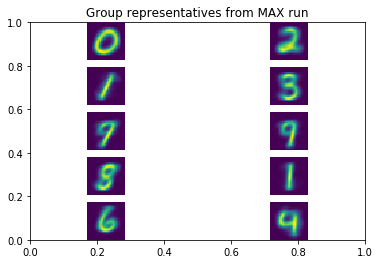

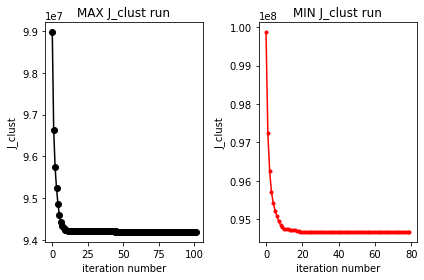

In [23]:
# Plot the min and max J_clust runs

MAX_run = out_data_master_1020[max_J_clust["Run"]]
MIN_run = out_data_master_1020[min_J_clust["Run"]]

fig = plt.figure()
plt.title('Group representatives from MAX run')

for i in range(np.shape(MAX_run["group_representatives"])[0]):
    
    image = np.array(MAX_run["group_representatives"])[i].reshape((28,28))
    sub = fig.add_subplot(5, 2, i + 1)
    plt.axis('off')
    sub.imshow(image)

fig = plt.figure()
plt.title('Group representatives from MIN run')

for i in range(np.shape(MIN_run["group_representatives"])[0]):
    
    image = np.array(MIN_run["group_representatives"])[i].reshape((28,28))
    sub = fig.add_subplot(5, 2, i + 1)
    plt.axis('off')
    sub.imshow(image)

# Convergence of J_clust in MAX and MIN runs
plt.subplot(1, 2, 1)
plt.plot(MAX_run["J_clust"], 'ko-')
plt.title('MAX J_clust run')
plt.xlabel('iteration number')
plt.ylabel('J_clust')


plt.subplot(1, 2, 2)
plt.plot(MIN_run["J_clust"], 'r.-')
plt.title('MIN J_clust run')
plt.xlabel('iteration number')
plt.ylabel('J_clust')

plt.tight_layout()

plt.show()

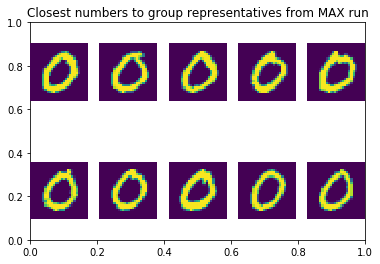

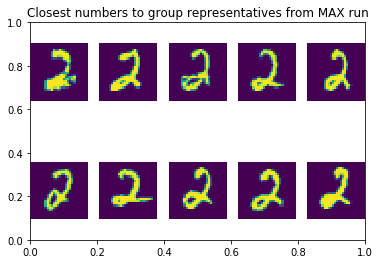

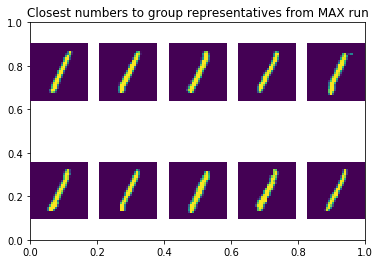

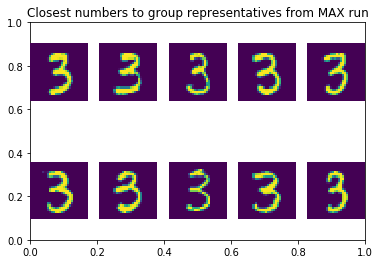

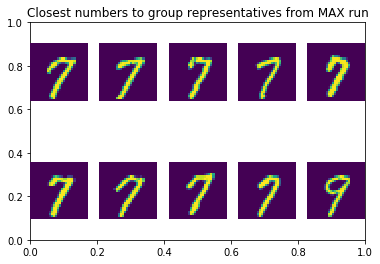

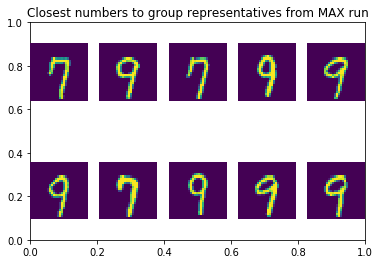

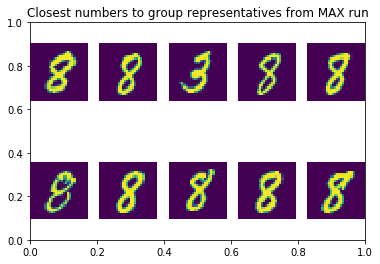

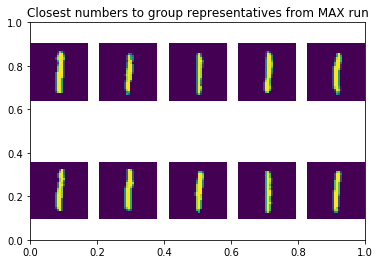

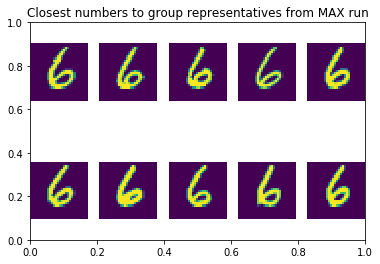

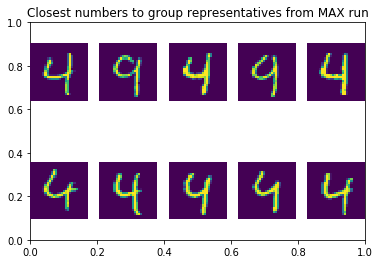

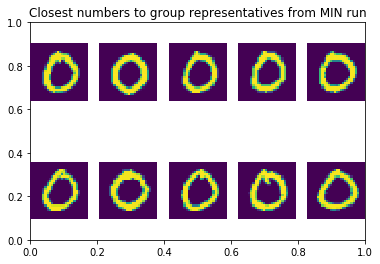

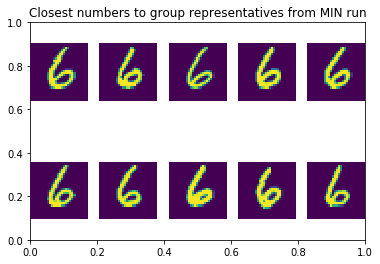

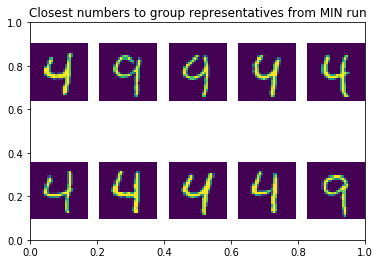

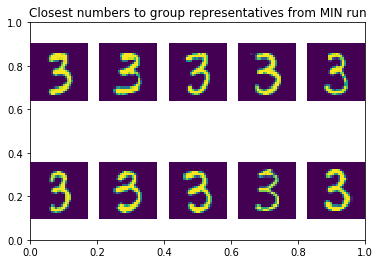

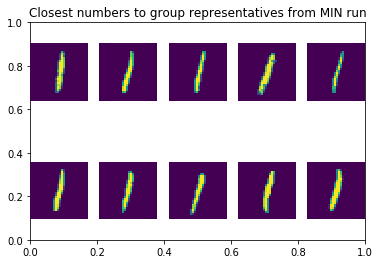

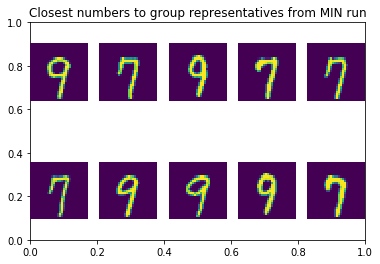

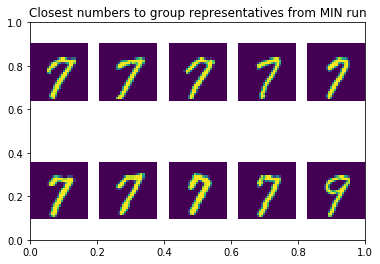

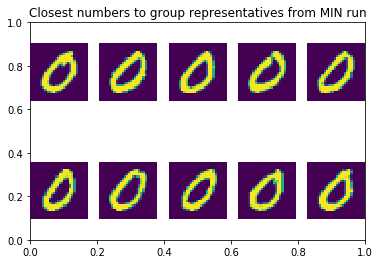

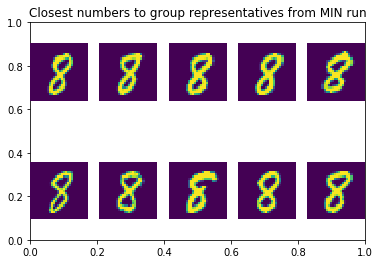

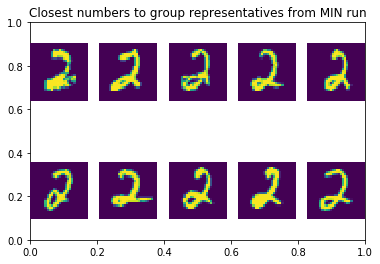

In [24]:
# Print the closest ten data vectors to the group representatives of the max and min runs:
closest_10_for_each_grouprep_MAX = find_closest_10(MAX_run["distances_to_reps"])
closest_10_for_each_grouprep_MIN = find_closest_10(MIN_run["distances_to_reps"])

for index in range(np.shape(closest_10_for_each_grouprep_MAX)[0]):
    
    fig = plt.figure()
    plt.title('Closest numbers to group representatives from MAX run')
    for index_inner in range(np.shape(closest_10_for_each_grouprep_MAX)[1]):
        
        image = data_list[int(closest_10_for_each_grouprep_MAX[index,index_inner])].reshape((28,28))
        sub = fig.add_subplot(2, 5, index_inner + 1)
        plt.axis('off')
        sub.imshow(image)

for index in range(np.shape(closest_10_for_each_grouprep_MIN)[0]):
    
    fig = plt.figure()
    plt.title('Closest numbers to group representatives from MIN run')
    for index_inner in range(np.shape(closest_10_for_each_grouprep_MIN)[1]):
        
        image = data_list[int(closest_10_for_each_grouprep_MIN[index,index_inner])].reshape((28,28))
        sub = fig.add_subplot(2, 5, index_inner + 1)
        plt.axis('off')
        sub.imshow(image)

In [38]:
jclus = []

for i in range(30):
    jclus.append(out_data_master_2030[i]["J_clust"][-1])

np.sort(np.array(jclus))

array([88858587.64025879, 88870786.94506836, 88871174.51068115,
       88871585.82324219, 88909786.14434814, 88916002.9562378 ,
       88916578.66168213, 88928550.36688232, 88957604.7689209 ,
       89000423.74127197, 89070336.25646973, 89095275.93017578,
       89105861.05749512, 89106713.76715088, 89106821.1472168 ,
       89109517.56365967, 89110157.08227539, 89124193.17474365,
       89130990.7154541 , 89156583.69750977, 89156973.10229492,
       89159619.65167236, 89166137.534729  , 89180506.42944336,
       89207439.12329102, 89214332.7843628 , 89242623.40759277,
       89254172.21166992, 89301031.89648438, 89368067.20581055])

## Statistics for K = 10, 20 iterations

Computing similar statistics for as we did before, for K=10 with 20 iterations!

$J_{clust}$ from max run: 94185750.95806885

$J_{clust}$ from min run: 95048205.77789307

Number of correct guesses based off observing 10 closest data points:
min: 91/100 (91 %)
max: 89/100 (89 %)

Most frequently misclassified numbers:
4 and 9

# k-means(data, K=5) for 10 iterations

In [11]:
out_data_master_0510 = []

for run in range(10):
    print("\n\n\n~~~~~~~~~~~~~~~Run number: %s~~~~~~~~~~~~~~~\n\n\n"%run)
    out_data = kmeans(data_list, 5)
    J_clust = out_data["J_clust"][-1]
    if run == 0:
        min_J_clust = {"Run": 0, "min_value": J_clust}
        max_J_clust = {"Run": 0, "max_value": J_clust}
    else:
        if J_clust > max_J_clust["max_value"]:
            max_J_clust["Run"] = run
            max_J_clust["max_value"] = J_clust
        
        if J_clust < min_J_clust["min_value"]:
            min_J_clust["Run"] = run
            min_J_clust["min_value"] = J_clust
                
    out_data_master_0510.append(out_data)






~~~~~~~~~~~~~~~Run number: 0~~~~~~~~~~~~~~~



Convergence: 31170 group assignments out of 60000
Convergence: 44150 group assignments out of 60000
Convergence: 50505 group assignments out of 60000
Convergence: 53963 group assignments out of 60000
Convergence: 56312 group assignments out of 60000
Convergence: 57730 group assignments out of 60000
Convergence: 58329 group assignments out of 60000
Convergence: 58424 group assignments out of 60000
Convergence: 58353 group assignments out of 60000
Convergence: 58387 group assignments out of 60000
Convergence: 58808 group assignments out of 60000
Convergence: 59215 group assignments out of 60000
Convergence: 59473 group assignments out of 60000
Convergence: 59648 group assignments out of 60000
Convergence: 59775 group assignments out of 60000
Convergence: 59837 group assignments out of 60000
Convergence: 59878 group assignments out of 60000
Convergence: 59912 group assignments out of 60000
Convergence: 59935 group assignments out of 60000


Convergence: 45836 group assignments out of 60000
Convergence: 52615 group assignments out of 60000
Convergence: 55162 group assignments out of 60000
Convergence: 55933 group assignments out of 60000
Convergence: 57108 group assignments out of 60000
Convergence: 58462 group assignments out of 60000
Convergence: 59210 group assignments out of 60000
Convergence: 59560 group assignments out of 60000
Convergence: 59725 group assignments out of 60000
Convergence: 59836 group assignments out of 60000
Convergence: 59871 group assignments out of 60000
Convergence: 59913 group assignments out of 60000
Convergence: 59932 group assignments out of 60000
Convergence: 59944 group assignments out of 60000
Convergence: 59961 group assignments out of 60000
Convergence: 59967 group assignments out of 60000
Convergence: 59982 group assignments out of 60000
Convergence: 59987 group assignments out of 60000
Convergence: 59993 group assignments out of 60000
Convergence: 59995 group assignments out of 60000


Convergence: 30843 group assignments out of 60000
Convergence: 48777 group assignments out of 60000
Convergence: 55162 group assignments out of 60000
Convergence: 57025 group assignments out of 60000
Convergence: 58126 group assignments out of 60000
Convergence: 58792 group assignments out of 60000
Convergence: 59185 group assignments out of 60000
Convergence: 59454 group assignments out of 60000
Convergence: 59597 group assignments out of 60000
Convergence: 59693 group assignments out of 60000
Convergence: 59779 group assignments out of 60000
Convergence: 59819 group assignments out of 60000
Convergence: 59888 group assignments out of 60000
Convergence: 59904 group assignments out of 60000
Convergence: 59924 group assignments out of 60000
Convergence: 59938 group assignments out of 60000
Convergence: 59952 group assignments out of 60000
Convergence: 59977 group assignments out of 60000
Convergence: 59982 group assignments out of 60000
Convergence: 59986 group assignments out of 60000


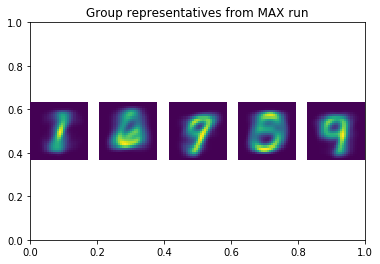

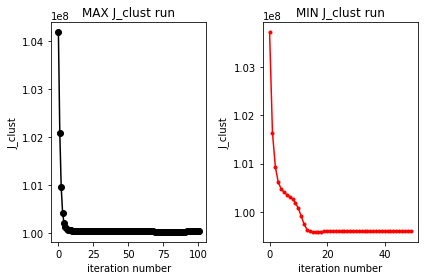

In [32]:
# Plot the min and max J_clust runs

MAX_run = out_data_master_0510[max_J_clust["Run"]]
MIN_run = out_data_master_0510[min_J_clust["Run"]]

fig = plt.figure()
plt.title('Group representatives from MAX run')

for i in range(np.shape(MAX_run["group_representatives"])[0]):
    
    image = np.array(MAX_run["group_representatives"])[i].reshape((28,28))
    sub = fig.add_subplot(1, 5, i + 1)
    plt.axis('off')
    sub.imshow(image)

fig = plt.figure()
plt.title('Group representatives from MIN run')

for i in range(np.shape(MIN_run["group_representatives"])[0]):
    
    image = np.array(MIN_run["group_representatives"])[i].reshape((28,28))
    sub = fig.add_subplot(1, 5, i + 1)
    plt.axis('off')
    sub.imshow(image)

# Convergence of J_clust in MAX and MIN runs
plt.subplot(1, 2, 1)
plt.plot(MAX_run["J_clust"], 'ko-')
plt.title('MAX J_clust run')
plt.xlabel('iteration number')
plt.ylabel('J_clust')


plt.subplot(1, 2, 2)
plt.plot(MIN_run["J_clust"], 'r.-')
plt.title('MIN J_clust run')
plt.xlabel('iteration number')
plt.ylabel('J_clust')

plt.tight_layout()

plt.show()

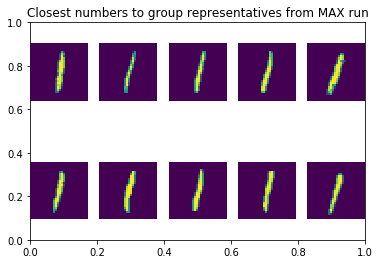

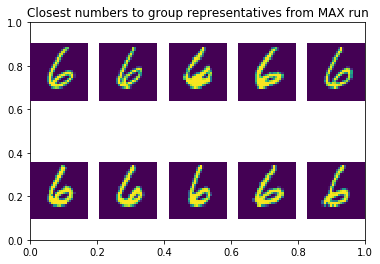

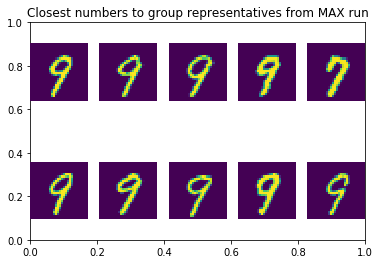

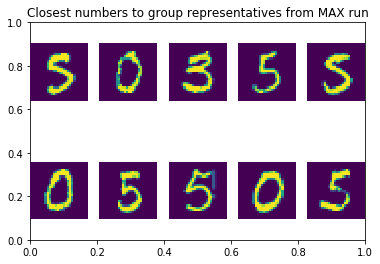

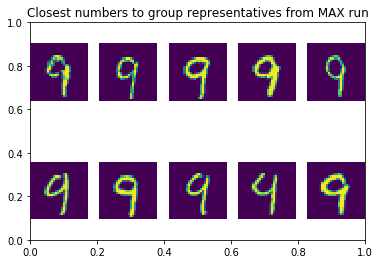

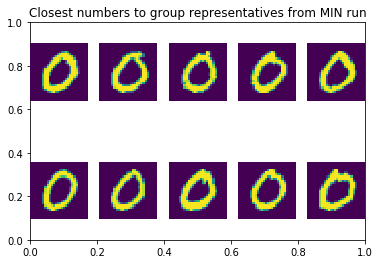

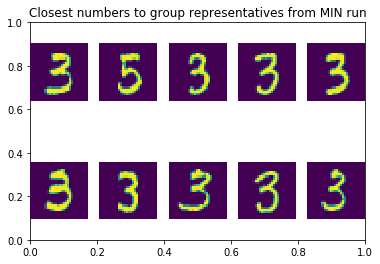

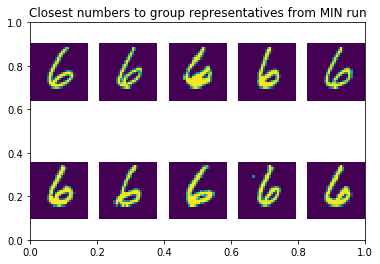

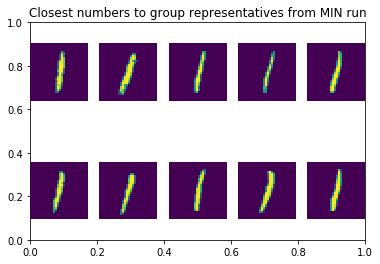

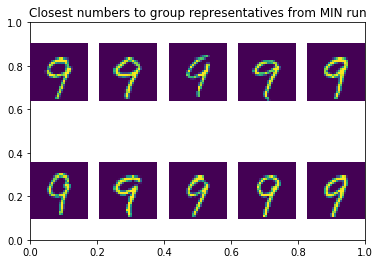

In [27]:
# Print the closest ten data vectors to the group representatives of the max and min runs:
closest_10_for_each_grouprep_MAX = find_closest_10(MAX_run["distances_to_reps"])
closest_10_for_each_grouprep_MIN = find_closest_10(MIN_run["distances_to_reps"])

# print(np.shape(MAX_run["distances_to_reps"]))
# print(np.shape(closest_10_for_each_grouprep_MAX)[0])

for index in range(np.shape(closest_10_for_each_grouprep_MAX)[0]):
    
    fig = plt.figure()
    plt.title('Closest numbers to group representatives from MAX run')
    for index_inner in range(np.shape(closest_10_for_each_grouprep_MAX)[1]):
        
        image = data_list[int(closest_10_for_each_grouprep_MAX[index,index_inner])].reshape((28,28))
        sub = fig.add_subplot(2, 5, index_inner + 1)
        plt.axis('off')
        sub.imshow(image)

for index in range(np.shape(closest_10_for_each_grouprep_MIN)[0]):
    
    fig = plt.figure()
    plt.title('Closest numbers to group representatives from MIN run')
    for index_inner in range(np.shape(closest_10_for_each_grouprep_MIN)[1]):
        
        image = data_list[int(closest_10_for_each_grouprep_MIN[index,index_inner])].reshape((28,28))
        sub = fig.add_subplot(2, 5, index_inner + 1)
        plt.axis('off')
        sub.imshow(image)

In [33]:


print(max_J_clust["max_value"]/min_J_clust["min_value"])
print(min_J_clust["min_value"])
print(max_J_clust["max_value"])

1.0042590045044535
99607179.07995605
100031406.5043335


## Statistics for K = 5, 10 iterations

Computing similar statistics for as we did before, for K=5 with 10 iterations!

$J_{clust}$ from max run: 99607179.07

$J_{clust}$ from min run: 100031406.50

Number of correct guesses based off observing 10 closest data points:
min: 49/50 (98 %)
max: 44/100 (88 %)

Most frequently misclassified numbers:
4 and 9
5, 3, and 0

# Comparing the three trials

We ran the k-means clustering algorithm on the same data set under three different sets of parameters:
- First trial: K = 20, 30 iterations
- Second trial: K = 10, 20 iterations
- Third trial: K = 5, 10 iterations

What we discovered through the statistics that we computed on each of these trials (see individual trial sections above for numerical details), was that the total error (measured as the sum total Euclidian distance between each group representative and it's group members) was actually *less* when we introduced more group representatives. This might be counter intuitive because we'd suspect that adding more variables into this summation would make it higher; in actuality, although it created more group representatives, the distance to each group representative was much more optimized!

Another key observation to make is that although we computed the accuracy for each trial from the minimum and maximum $J_{clust}$ runs, this measure has two vulneratbilities:
1. It is susceptible to human subjectivity because I must make look at the group representatives and classify them to a digit visually
2. If a trial's final group representatives converged to numbers that are naturally more susceptible to misclassification (like 4 and 9), this would result in a higher error rate.

Overall, we can still say that the k-means clustering algorithm did decently well in clustering a massive array of numbers, despite some of them being "noisy". 